# Investigation into Best Location for Opening a New Brewery

## By Tom Kenny for Coursera Capstone Project

_“Beer is proof that God loves us and wants us to be happy._ ― __Benjamin Franklin__

### Problem Description: ###

Ok, Ben Franklin never said that, but as far as often quoted misquotes go, it is of the highest
quality. But beyond being just an enjoyable pint, beer is also big business. Forget about the
big multinationals. According to The Brewers Association, the craft brewing industry
contributed $79.1 billion to the U.S. economy in 2018, more than 550,000 jobs(1). Nationally,
the number of craft breweries is growing, though the annual growth rate is decelerating. The
growth rate was 21% from 2014-2015 and has fallen to 13% from 2017-2018(2).
That being said, if you want to investigate the possibility of opening a brewery, some thing to
consider would be the potential market (the population of a given area), and how that market
is currently being served (number of breweries within a given radius).

### Target Audience: ###

Any group or individual contemplating the brewery business and the possibility of opening
or buying a brewery.
The analysis, while limited to a single U.S. state and a single type of venue, could easily be
tailored to any location and any venue type in the Foursquare database.

### Data and its Usage: ###

For this report, I will investigate population centers (by zip code) in the U.S. state of Indiana.
This information is available from the U.S. Census Bureau via API. Within the report I will
obtain the population for each zip code in the state. Then a limit (which can be changed) will
be set and populations below this number will be dropped.
Given a zip code, Nominatim will be used to retrieve a latitude and longitude associated with
the zip code, and this lat./long. data will be used in making calls to Foursquare. Information
returned by Foursquare will in be a list of breweries within a given radius. The count of the
breweries and the population (and the name associated with the zip code) will be analyzed
with the intent of finding an area with a relatively high population and a relatively low
number of breweries already present.

As a first order of business, I will download various needed libraries.  This notebook was developed locally using Anaconda 3 with a virtual environment containing the needed libraries.  If they are not present (conda-forge geopy, folium) then uncomment the #!conda install lines.  Some of these libraries are not used in the first part of the project, but are loaded now by convention.

In [1]:
import numpy as np # library to handle data in a vectorized manner

In [2]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [3]:
import json # library to handle JSON files

In [4]:
import requests # library to handle requests

In [5]:
# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors

In [6]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [7]:
import folium # map rendering library

This is a little helper function that, when called, displays a progress bar for any lengthy operation

In [8]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 100
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

I have these items installed locally, but you may uncomment them to install if needed.

In [9]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab

## Phase 1 - Gathering basic data for Breweries in Indiana, USA

## 1. Download Dataset

I will be using foursquare to generate venue data.  Codes below allow calls to be made.

In [1]:
CLIENT_ID = 'F3SQKWY1C2VSBLT2OHLDAYZHCCLBOZK0PY5YTA**********' # your Foursquare ID
CLIENT_SECRET = 'T2AW5J5LTZZYVKIBE1MZ51TK1WFCLO5E2VW1XI**********' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 50
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: F3SQKWY1C2VSBLT2OHLDAYZHCCLBOZK0PY5YTA**********
CLIENT_SECRET:T2AW5J5LTZZYVKIBE1MZ51TK1WFCLO5E2VW1XI**********


First, I am interested in cities/towns with population > some lower limit.  I will start by building a dataframe consisting of all zip codes in the state of Indiana.  The range for these codes is 46000 to 47999. But rather than make 2,000 calls to the census, I have a csv file of active zip codes in that range.

In [11]:
zipcodeurl="https://raw.githubusercontent.com/tkenny76/Coursera_Capstone/master/ZIP_IN.csv"
zipcodedf=pd.read_csv(zipcodeurl)
zipcodedf.head()

,ZIP
0,46001
1,46011
2,46012
3,46013
4,46016


In [12]:
CENSUSKEY = 'c449e82d0d81d639a1512d6ea498b2**********'  # Obscured Intentionally
#census_url='https://api.census.gov/data/2017/acs/acs5?key='+ CENSUSKEY +'&get=B01003_001E&for=zip%20code%20tabulation%20area:46531'
#https://api.census.gov/data/2010/dec/sf1?get=NAME,P001001&for=county:%2A&in=state:36     --90807--
#resp=requests.get(census_url)
#resp

This function returns the 2018 census population associated with the input zip code.

In [13]:
def getpop(pc):
    # print(pc)
    census_url='https://api.census.gov/data/2018/acs/acs5?key='+ CENSUSKEY +'&get=B01003_001E&for=zip%20code%20tabulation%20area:' + pc
    #print(census_url)
    #--90807--
    try:
        resp=requests.get(census_url)
        #print(resp)
        #print(resp.text)
        pop = int(resp.text.split('"')[5])
        # print('in try, pc= ', pc, ' pop= ', pop)
        return pop
    except:
        # print('in except, pc= ', pc)
        return -1

In [14]:
popdf = pd.DataFrame({'zipcode':[], 'population':[]})
popdf

,zipcode,population


In [15]:
number_of_elements = len(zipcodedf)
i=0
for index, row in zipcodedf.iterrows():
    update_progress(i / number_of_elements)
    pc=str(int(row['ZIP']))
    popdf.loc[index, 'zipcode'] = pc
    popdf.loc[index, 'population'] = getpop(pc)
    #make up to three tries to get good data if error received:
    if popdf.loc[index, 'population'] == -1:
        popdf.loc[index, 'population'] = getpop(pc)
    if popdf.loc[index, 'population'] == -1:
        popdf.loc[index, 'population'] = getpop(pc)
    if popdf.loc[index, 'population'] == -1:
        popdf.loc[index, 'population'] = getpop(pc)
    i+=1
update_progress(1)

popdf.head()

Progress: [####################################################################################################] 100.0%


,zipcode,population
0,46001,9948.0
1,46011,17467.0
2,46012,19394.0
3,46013,16988.0
4,46016,17996.0


In [16]:
popdf.describe()

,population
count,775.000000
mean,8564.154839
std,11650.206548
min,0.000000
25%,1060.500000
50%,3142.000000
75%,11408.500000
max,75899.000000


Copy to a new dataframe, dropping zip codes with zero population

In [17]:
citydf=popdf.drop(popdf[popdf.population == 0].index)
#citydf=citydf.reset_index()

In [18]:
citydf.head()

,zipcode,population
0,46001,9948.0
1,46011,17467.0
2,46012,19394.0
3,46013,16988.0
4,46016,17996.0


In [19]:
citydf.describe()

,population
count,770.000000
mean,8619.766234
std,11667.468634
min,5.000000
25%,1078.250000
50%,3162.500000
75%,11454.500000
max,75899.000000


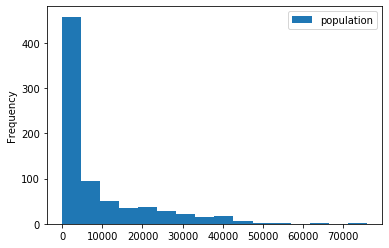

In [20]:
citydf.plot.hist(citydf['population'], bins=16)

In [21]:
citydf.describe()

,population
count,770.000000
mean,8619.766234
std,11667.468634
min,5.000000
25%,1078.250000
50%,3162.500000
75%,11454.500000
max,75899.000000


Now import Nominatim to convert Zip Codes to latitude and longitude:

In [22]:
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

The search radius is also arbitrary. How far would you drive for a freshly crafted beer? Lest say 20 miles (32.187 km)

Foursquare does not have separate entries for different styles of brewery (regional brewery, microbrewery, and brewpub) so as I pull data from Foursquare, I will also generate a list of all breweries included in the data:

In [23]:
brewery_list = {}

In [24]:
search_query = 'Brewery'
radius = 32187 # meters = 20 miles

In [25]:
geolocator = Nominatim(user_agent="foursquare_agent")

So now, for each Zip Code, get the latitude, longitude, and name, get a list of breweries within the search radius, and count them. Add this information to the dataframe.

In [26]:
number_of_elements = len(citydf)
i=0
for index, row in citydf.iterrows():
    i += 1
    update_progress(i / number_of_elements)
    address_in = {'postalcode': row['zipcode']}
    try:
        location = geolocator.geocode(address_in, country_codes='US')
        latitude = location.latitude
        longitude = location.longitude
        address_out = location.address
        address_out=address_out[:address_out.find(',')]
        citydf.loc[index,'latitude'] = latitude
        citydf.loc[index,'longitude'] = longitude
        citydf.loc[index,'address'] = address_out
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
        results = requests.get(url).json()
        venues = results['response']['venues']
        dataframe = json_normalize(venues)
        for j in range(len(dataframe)):
            brewery_list[dataframe.loc[j,'id']]= dataframe.loc[j,'name']
        
        citydf.loc[index,'brewery_count'] = len(dataframe.index)
    except:
        #try again:
        try:
            location = geolocator.geocode(address_in, country_codes='US')
            latitude = location.latitude
            longitude = location.longitude
            address_out = location.address
            address_out=address_out[:address_out.find(',')]
            citydf.loc[index,'latitude'] = latitude
            citydf.loc[index,'longitude'] = longitude
            citydf.loc[index,'address'] = address_out
            url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
            results = requests.get(url).json()
            venues = results['response']['venues']
            dataframe = json_normalize(venues)
            for j in range(len(dataframe)):
                brewery_list[dataframe.loc[j,'id']]= dataframe.loc[j,'name']

            citydf.loc[index,'brewery_count'] = len(dataframe.index)
        except:
            print("Error processing postal code ",citydf.loc[index, 'zipcode'])
            citydf.loc[index,'brewery_count'] = -1
update_progress(1)
    

Progress: [####################################################################################################] 100.0%


In [27]:
sorted(brewery_list.values())

['10-56 Brewery',
 '10-56 Brewery',
 '11th Ave Brewery',
 '13 Below Brewery',
 '18th Street Brewery',
 '18th Street Brewery',
 '18th Street Brewery',
 '3 Floyds Brewery & Pub',
 '3 Points Urban Brewery',
 '3 Wiseman Brewery',
 '309 Brewery',
 '5 Rabbit Brewery',
 'Adams Street Brewery',
 'Against The Grain Brewery & Smokehouse',
 'Against the Grain Brewery Portland',
 'Argus Brewery',
 'Auburn  Brewery',
 'Back Alley Brewery',
 'Back Road Brewery',
 'Backstep Brewery',
 'Bad Dad Brewery',
 'Bakers Brewery',
 'Baldwinian Brewery',
 'Ball & Chain Brewery',
 'Bare Hands Brewery',
 'Bare Hands Brewery - South Bend',
 'Bier Brewery North',
 'Bier Brewery Taproom',
 'Big Herm Brewery',
 'Big Thorn Farm & Brewery',
 'Big Woods Brewery',
 'Black Acre Production Brewery',
 'Blind Owl Brewery',
 'Bliss Ave Brewery',
 'Bluegrass Brewing Company',
 'Boal Brewery',
 'Border Town Pub Brewery & Eatery',
 'Braxton Brewing Company',
 'Brewer Yard',
 'Brewery Tour',
 'Brewery Tours of Indianapolis',
 'B

In [28]:
len(brewery_list)

261

In [29]:
citydf.head()

,zipcode,population,latitude,longitude,address,brewery_count
0,46001,9948.0,40.254230,-85.668335,Alexandria,6.0
1,46011,17467.0,40.112133,-85.731220,Anderson,11.0
2,46012,19394.0,40.128237,-85.648630,Anderson,10.0
3,46013,16988.0,40.061709,-85.679867,Anderson,10.0
4,46016,17996.0,40.098489,-85.680501,Anderson,9.0


And now lets take a look at what we have

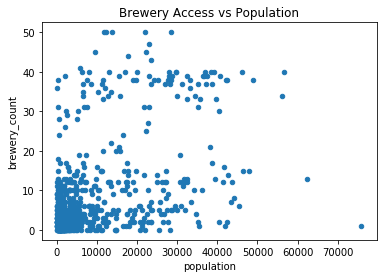

In [30]:
citydf.plot.scatter(x='population', y='brewery_count', title='Brewery Access vs Population')

This raw data does not lend itself to any simple model.  Perhaps there is something to be learned by k-means clustering.  This clustering will performed not as a prediction tool, but to characterize existing data.

In [31]:
import random
np.random.seed(46528)

In [32]:
cdf = citydf.drop(['zipcode','latitude','longitude','address'], axis=1)
cdf.head()

,population,brewery_count
0,9948.0,6.0
1,17467.0,11.0
2,19394.0,10.0
3,16988.0,10.0
4,17996.0,9.0


In [33]:
from sklearn.preprocessing import StandardScaler

the X datset will contain data for population and brewery_count.

In [34]:
X = cdf.values[:,:]
X

array([[9.9480e+03, 6.0000e+00],
       [1.7467e+04, 1.1000e+01],
       [1.9394e+04, 1.0000e+01],
       ...,
       [3.0100e+02, 2.0000e+00],
       [1.7320e+03, 0.0000e+00],
       [1.1800e+02, 1.0000e+00]])

In [35]:
X = np.nan_to_num(X)

Now I want to transform the data due to the units and ranges being quite different.

In [36]:
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[ 0.11391478, -0.22262186],
       [ 0.75877507,  0.21736488],
       [ 0.9240425 ,  0.12936753],
       ...,
       [-0.71345153, -0.57461125],
       [-0.59072309, -0.75060594],
       [-0.72914636, -0.6626086 ]])

Next, I will plot the k means clusters for 5, 4, 3 and 2 clusters, bearing in mind that I am hoping to isolate a cluster that represents a relatively high population with relatively fewer existing breweries.

In [37]:
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(Clus_dataSet)
labels = k_means.labels_

In [38]:
citydf['cluster_num']=labels
citydf.head()

,zipcode,population,latitude,longitude,address,brewery_count,cluster_num
0,46001,9948.0,40.254230,-85.668335,Alexandria,6.0,0
1,46011,17467.0,40.112133,-85.731220,Anderson,11.0,2
2,46012,19394.0,40.128237,-85.648630,Anderson,10.0,2
3,46013,16988.0,40.061709,-85.679867,Anderson,10.0,2
4,46016,17996.0,40.098489,-85.680501,Anderson,9.0,2


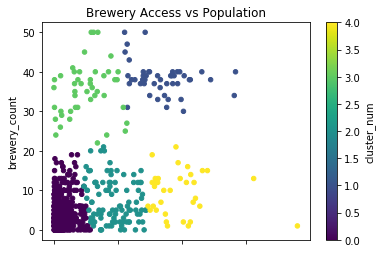

In [40]:
citydf.plot.scatter(x='population', y='brewery_count', c='cluster_num', colormap='viridis', title='Brewery Access vs Population', )

The clusters here are not extremely distinct.  They appear to relate to one another as follows: On top, there are cities with a high number (twenty +) of venues (breweries) with the population split at above/below 25,000.  And there are three clusters with twenty or fewer venues, with populations roughly broken down as less than five thousand, five to fifteen thousand, and fifteen thousand plus.  The cluster that may have the best prospect is cluster 4, which covers the bottom right quadrant of the chart.  

For completeness, I will check from 4 down to 2 clusters, but basically, the cluster mentioned above is the most favorable

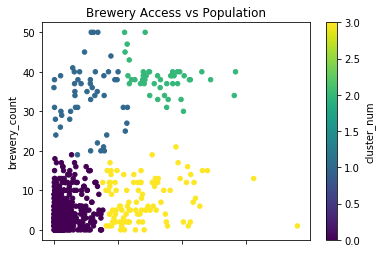

In [41]:
clusterNum = 4
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(Clus_dataSet)
labels = k_means.labels_
citydf['cluster_num']=labels
citydf.head()
citydf.plot.scatter(x='population', y='brewery_count', c='cluster_num', colormap='viridis', title='Brewery Access vs Population')


With either three or four clusters, the two lower right clusters from the five cluster scenario merge in to one.  This now represents cities with 20 or fewer breweries available and fifteen thousand or more in population.

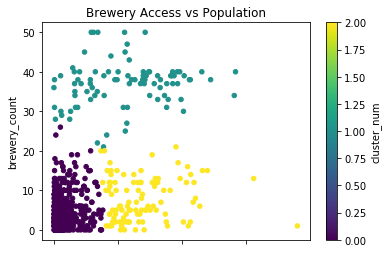

In [42]:
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(Clus_dataSet)
labels = k_means.labels_
citydf['cluster_num']=labels
citydf.head()
citydf.plot.scatter(x='population', y='brewery_count', c='cluster_num', colormap='viridis', title='Brewery Access vs Population')


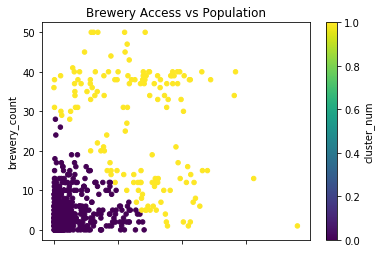

In [43]:
clusterNum = 2
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(Clus_dataSet)
labels = k_means.labels_
citydf['cluster_num']=labels
citydf.head()
citydf.plot.scatter(x='population', y='brewery_count', c='cluster_num', colormap='viridis', title='Brewery Access vs Population')


Nothing is useful in the two cluster model, so I will regenerate the three cluster model:

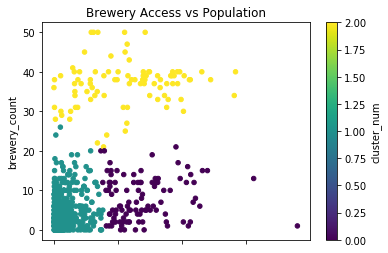

In [44]:
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(Clus_dataSet)
labels = k_means.labels_
citydf['cluster_num']=labels
citydf.head()
citydf.plot.scatter(x='population', y='brewery_count', c='cluster_num', colormap='viridis', title='Brewery Access vs Population')


For later analysis, I am interested in the number of breweries that, on the high end, a population can support.  Fot that I will extract cluster 2:

In [61]:
hi_brew_df = citydf.drop(citydf[citydf.cluster_num == 0].index)
hi_brew_df = hi_brew_df.drop(hi_brew_df[hi_brew_df.cluster_num == 1].index)


The cluster 0 dots are of interest, so I will extract a new dataframe with just them:

In [46]:
best_citydf = citydf.drop(citydf[citydf.cluster_num == 1].index)

In [47]:
best_citydf = best_citydf.drop(best_citydf[best_citydf.cluster_num == 2].index)

In [48]:
best_citydf.describe()

,population,latitude,longitude,brewery_count,cluster_num
count,102.000000,102.000000,102.000000,102.000000,102.0
mean,27553.313725,40.220433,-86.188636,7.921569,0.0
std,10381.686002,1.223047,0.824661,5.422152,0.0
min,14644.000000,37.960635,-87.650495,0.000000,0.0
25%,19388.000000,39.193085,-86.906101,3.250000,0.0
50%,25634.000000,40.432682,-86.107099,7.000000,0.0
75%,31944.750000,41.316108,-85.546885,12.000000,0.0
max,75899.000000,41.742531,-84.896210,21.000000,0.0


So these populations range from 14,644 to 75,899.  And brewery access ranges from 0 to 21.

Now lets see this all on a map.  This first map shows all cities in the state (actually, Zip Codes)

In [49]:
center_lat=39.962604
center_long=-86.174761

In [50]:
# create map of Indiana using latitude and longitude values
t_latitude = center_lat
t_longitude = center_long
map_indiana = folium.Map(width=400, height=600, location=[t_latitude, t_longitude], zoom_start=7)
# add markers to map
for blat, blng, bbrw, cpop, cname in zip(citydf['latitude'], citydf['longitude'], citydf['brewery_count'], citydf['population'], citydf['address']):
    label = '{}'.format(cname)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [blat, blng],
        radius = cpop/10000,  #cpop/(5000*(bbrw+1)),
        #radius=bbrw/3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_indiana)  
title_html = '<h3 align="center" style="font-size:20px"><b>Indiana Cities by Population per Zip Code</b></h3>'
map_indiana.get_root().html.add_child(folium.Element(title_html))
    
map_indiana

Next, a map with markers sized to indicate access to breweries

In [51]:
# create map of Indiana using latitude and longitude values
t_latitude = center_lat
t_longitude = center_long
map_indiana = folium.Map(width=400, height=600, location=[t_latitude, t_longitude], zoom_start=7)
# add markers to map
for blat, blng, bbrw, cpop, cname in zip(citydf['latitude'], citydf['longitude'], citydf['brewery_count'], citydf['population'], citydf['address']):
    label = '{}'.format(cname)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [blat, blng],
        radius = bbrw/5,  #cpop/(5000*(bbrw+1)),
        #radius=bbrw/3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_indiana)  
title_html = '<h3 align="center" style="font-size:20px"><b>Indiana Cities by Brewery Proximity per Zip Code</b></h3>'
map_indiana.get_root().html.add_child(folium.Element(title_html))
    
map_indiana

Finally, generate a map of just the cities in the preferred cluster(s),with marker size proportional to population and inversely proportional to number of existing breweries in the area:

In [52]:
# create map of Indiana using latitude and longitude values
t_latitude = center_lat
t_longitude = center_long
map_indiana = folium.Map(width=400, height=600, location=[t_latitude, t_longitude], zoom_start=7)
# add markers to map
for blat, blng, bbrw, cpop, cname in zip(best_citydf['latitude'], best_citydf['longitude'], best_citydf['brewery_count'], best_citydf['population'], best_citydf['address']):
    label = '{}'.format(cname)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [blat, blng],
        radius = cpop/(5000*(bbrw+1)),
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_indiana)  
    
map_indiana

Some of this looks interesting, so i will now incorporate this score into the dataframe:

In [53]:
for index, row in best_citydf.iterrows():
    best_citydf.loc[index, 'score'] = best_citydf.loc[index, 'population']/(5000*(best_citydf.loc[index, 'brewery_count']+1))

best_citydf = best_citydf.sort_values(by='score', ascending=False)

In [58]:
best_citydf.describe()

,population,latitude,longitude,brewery_count,cluster_num,score
count,102.000000,102.000000,102.000000,102.000000,102.0,102.000000
mean,27553.313725,40.220433,-86.188636,7.921569,0.0,1.086560
std,10381.686002,1.223047,0.824661,5.422152,0.0,1.225048
min,14644.000000,37.960635,-87.650495,0.000000,0.0,0.139467
25%,19388.000000,39.193085,-86.906101,3.250000,0.0,0.420984
50%,25634.000000,40.432682,-86.107099,7.000000,0.0,0.657057
75%,31944.750000,41.316108,-85.546885,12.000000,0.0,1.185894
max,75899.000000,41.742531,-84.896210,21.000000,0.0,7.589900


In [54]:
best_citydf.head(25)

,zipcode,population,latitude,longitude,address,brewery_count,cluster_num,score
714,47906,75899.0,40.455052,-86.942351,West Lafayette,1.0,0,7.589900
350,46947,28125.0,40.756582,-86.363175,Logansport,0.0,0,5.625000
628,47591,25416.0,38.670561,-87.505190,Vincennes,0.0,0,5.083200
470,47250,21984.0,38.781550,-85.381820,Madison,0.0,0,4.396800
713,47905,41910.0,40.418312,-86.825479,Lafayette,1.0,0,4.191000
68,46135,20800.0,39.649623,-86.871352,Greencastle,0.0,0,4.160000
325,46902,35403.0,40.446393,-86.132002,Howard County,1.0,0,3.540300
716,47909,42532.0,40.385986,-86.887002,Norma Jean Addition,2.0,0,2.835467
324,46901,40357.0,40.495531,-86.141938,Howard County,2.0,0,2.690467
667,47802,35054.0,39.452214,-87.413517,Terre Haute,2.0,0,2.336933


Now returning to the higher population data, what can be learned about the number of breweries a given population can support?

In [62]:
hi_brew_df.describe()

,population,latitude,longitude,brewery_count,cluster_num
count,90.000000,90.000000,90.000000,90.000000,90.0
mean,22301.055556,40.129692,-86.378393,36.866667,2.0
std,13659.832068,0.714678,0.552972,5.765453,0.0
min,15.000000,39.275296,-87.511738,21.000000,2.0
25%,11387.750000,39.732267,-86.388323,34.000000,2.0
50%,22499.000000,39.837575,-86.177661,38.000000,2.0
75%,32928.250000,39.987375,-86.063600,40.000000,2.0
max,56614.000000,41.678662,-84.878270,50.000000,2.0


The problem with this analysis is that it treats individual zip codes as population centers.  The maximum population is listed as 56,614.  Really, the entire Indianapolis metro area should be counted as a single population of about 2,000,000.
This 2,000,000 population suports roughly 60 breweries.

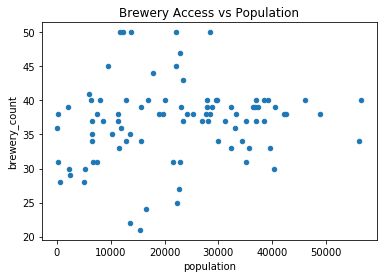

In [63]:
hi_brew_df.plot.scatter(x='population', y='brewery_count', title='Brewery Access vs Population')